In [73]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("xinwangcs/stressor-cause-of-mental-health-problem-dataset")
#print(path)

In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
FILES = []
for file in os.listdir(path):
    if file.endswith(".json"):
        PATH = os.path.join(path, file)
        FILES.append(PATH )
#print("Files in dataset:", FILES)



In [75]:
from nlprocess import load_data2dataframe

dataframes = [load_data2dataframe(f) for f in FILES]
df = pd.concat(dataframes, ignore_index=True)
df.head()

,text,stressor_class,stressor_word,interval
0,Why are there always trivial matters in life t...,T1,financial,8
1,"After celebrating my 21st birthday, I truly fe...",T1,urged to marry,8
2,"In the coming March, my work pressure will be ...",T1,work,8
3,"Indeed, the pressure of writing papers now is ...",T1,papers,8
4,"I can't learn it anymore, so let's just give u...",T1,can't learn it,8


In [76]:
df.dropna(inplace=True)
df.isna().sum()

text              0
stressor_class    0
stressor_word     0
interval          0
dtype: int64

In [77]:
from nlprocess import normalize_spacy
from nlprocess import to_corpus
import spacy
nlp = spacy.load("en_core_web_sm") 
Dict = to_corpus(df, "stressor_word", "bow" , nlp = nlp)

Building BOW Corpus: 100%|██████████| 3885/3885 [00:00<00:00, 647418.29it/s]


In [78]:
ddf , texts ,dictionary ,corpus = Dict["df"], Dict["texts"], Dict["dictionary"], Dict["corpus"]

In [79]:
ddf.head()

,text,stressor_class,stressor_word,interval,normalized
0,Why are there always trivial matters in life t...,T1,financial,8,[financial]
1,"After celebrating my 21st birthday, I truly fe...",T1,urged to marry,8,"[urge, marry]"
2,"In the coming March, my work pressure will be ...",T1,work,8,[work]
3,"Indeed, the pressure of writing papers now is ...",T1,papers,8,[paper]
4,"I can't learn it anymore, so let's just give u...",T1,can't learn it,8,[learn]


計算最佳主題數 4群 泛化能力稍佳
---

In [9]:
from find_best_number_of_topic import score_coherence
avg_values = score_coherence(dictionary , corpus, texts, "c_v", start=2, limit=10, num_runs=5, alpha='auto', eta='auto', passes=10)

Running coherence scores: 100%|██████████| 5/5 [05:31<00:00, 66.40s/it]


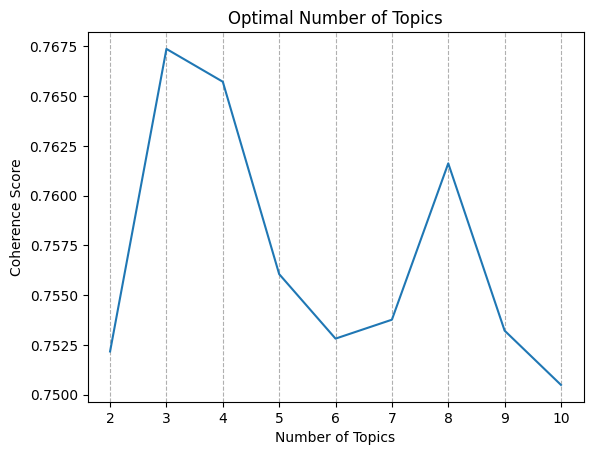

In [12]:

x = range(2,11)
plt.plot(x, np.mean(avg_values , axis=0))
plt.title("Optimal Number of Topics")
plt.grid(axis="x" , linestyle='--')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

Load model
---

In [80]:
# 讀取模型
from gensim.models import LdaModel
lda_model = LdaModel.load("LDA/topics_4_best_model.model")
# 取得每筆資料的主題分佈
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# 取最大主題編號作為群標籤
topic_labels = [max(dist, key=lambda x: x[1])[0] for dist in topic_distributions]

In [82]:
lda_model.print_topics()

[(0,
  '0.108*"exam" + 0.087*"study" + 0.070*"job" + 0.038*"home" + 0.027*"go" + 0.017*"friend" + 0.017*"panic" + 0.015*"expectation" + 0.014*"brother" + 0.013*"project"'),
 (1,
  '0.077*"school" + 0.041*"entrance" + 0.040*"family" + 0.037*"mom" + 0.035*"start" + 0.033*"graduate" + 0.030*"year" + 0.028*"examination" + 0.027*"new" + 0.020*"high"'),
 (2,
  '0.026*"peer" + 0.025*"academic" + 0.022*"social" + 0.020*"people" + 0.019*"house" + 0.017*"partner" + 0.016*"interview" + 0.015*"buy" + 0.015*"second" + 0.015*"performance"'),
 (3,
  '0.326*"work" + 0.163*"life" + 0.028*"parent" + 0.026*"money" + 0.017*"marry" + 0.016*"paper" + 0.014*"sister" + 0.012*"teacher" + 0.010*"urge" + 0.009*"student"')]

In [83]:
ddf["topic"] = topic_labels
ddf.head(10)

,text,stressor_class,stressor_word,interval,normalized,topic
0,Why are there always trivial matters in life t...,T1,financial,8,[financial],0
1,"After celebrating my 21st birthday, I truly fe...",T1,urged to marry,8,"[urge, marry]",3
2,"In the coming March, my work pressure will be ...",T1,work,8,[work],3
3,"Indeed, the pressure of writing papers now is ...",T1,papers,8,[paper],3
4,"I can't learn it anymore, so let's just give u...",T1,can't learn it,8,[learn],0
5,Staying up late is irreparable damage. I've st...,T1,learn,8,[learn],0
6,Watching decompressing videos on Douyin increa...,T1,decompressing videos,8,"[decompress, video]",2
7,The pressure from scrolling through Xiaohongsh...,T1,Xiaohongshu,8,[xiaohongshu],0
8,I'm out of money... the baby clothing store is...,T1,baby clothing store,8,"[baby, clothing, store]",0
9,All the pressure and obstacles are given by my...,T1,my family,8,[family],1


In [85]:
ddf["topic"].value_counts()

topic
3    1390
1     808
0     748
2     654
Name: count, dtype: int64

In [84]:
ddf.shape

(3600, 6)

# Data process

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X = ddf["text"]
y = ddf["topic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , stratify=y)


In [87]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from nlprocess import normalize_spacy
import spacy
nlp = spacy.load("en_core_web_sm") 
texts = [normalize_spacy(word , nlp) for word in X]
dictionary = Dictionary(texts)

X_train_tokens = [normalize_spacy(text, nlp) for text in X_train]
X_test_tokens = [normalize_spacy(text, nlp) for text in X_test]

X_train_vectorized = [dictionary.doc2bow(text) for text in X_train_tokens]
X_test_vectorized = [dictionary.doc2bow(text) for text in X_test_tokens]


tfidf_model = TfidfModel(X_train_vectorized)
X_train_tfidf = [tfidf_model[doc] for doc in X_train_vectorized]
X_test_tfidf = [tfidf_model[doc] for doc in X_test_vectorized]


In [88]:
from gensim import matutils
import numpy as np

# 將稀疏向量轉成稠密矩陣
def bow_to_dense(corpus, dictionary):
    return np.array([
        matutils.corpus2dense([bow], num_terms=len(dictionary)).T[0]
        for bow in corpus
    ])

X_train_vectorized = bow_to_dense(X_train_tfidf, dictionary)
X_test_vectorized = bow_to_dense(X_test_tfidf, dictionary)


In [89]:
X_train_vectorized.shape , X_test_vectorized.shape

((2880, 4687), (720, 4687))

# 模型比對


RandomForest
---

In [90]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report

RF = RandomForestClassifier(n_estimators=150 ,class_weight="balanced")
RF.fit(X_train_vectorized, y_train)  
y_pred = RF.predict(X_test_vectorized)  
print(RF.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.7097222222222223
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       150
           1       0.66      0.65      0.66       161
           2       0.67      0.50      0.57       131
           3       0.74      0.89      0.81       278

    accuracy                           0.71       720
   macro avg       0.70      0.67      0.68       720
weighted avg       0.71      0.71      0.70       720



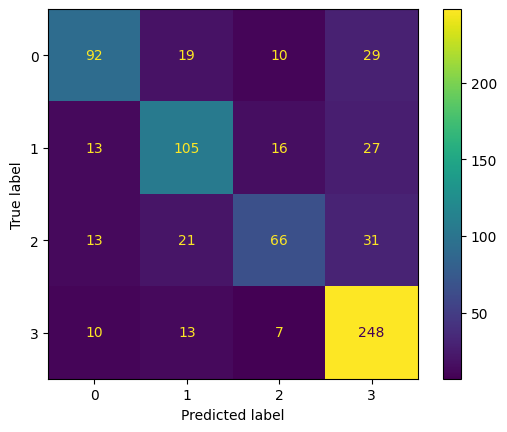

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(RF, X_test_vectorized, y_test)
plt.show()

linear-SVC
---

In [92]:
from sklearn.svm import LinearSVC
SVC_model = LinearSVC(
                        penalty="l1" ,
                        class_weight="balanced",
                        random_state=42
                    )
SVC_model.fit(X_train_vectorized, y_train)  
y_pred = SVC_model.predict(X_test_vectorized)  
print(SVC_model.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.7111111111111111
              precision    recall  f1-score   support

           0       0.72      0.65      0.69       150
           1       0.67      0.68      0.67       161
           2       0.60      0.60      0.60       131
           3       0.77      0.82      0.80       278

    accuracy                           0.71       720
   macro avg       0.69      0.69      0.69       720
weighted avg       0.71      0.71      0.71       720



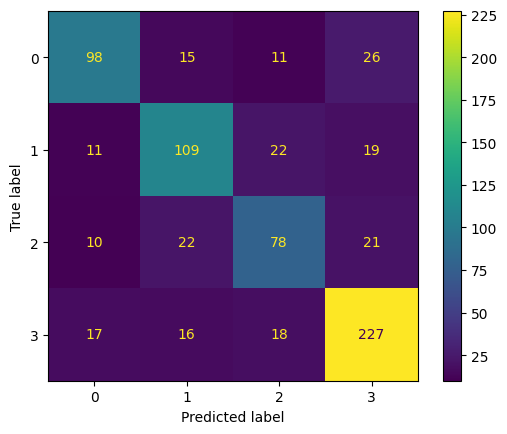

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(SVC_model, X_test_vectorized, y_test)
plt.show()

LogisticRegression
---

In [94]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(class_weight="balanced")
LR.fit(X_train_vectorized, y_train)  
y_pred = LR.predict(X_test_vectorized)  
print(LR.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.7083333333333334
              precision    recall  f1-score   support

           0       0.73      0.63      0.68       150
           1       0.65      0.66      0.65       161
           2       0.56      0.60      0.58       131
           3       0.81      0.83      0.82       278

    accuracy                           0.71       720
   macro avg       0.69      0.68      0.68       720
weighted avg       0.71      0.71      0.71       720



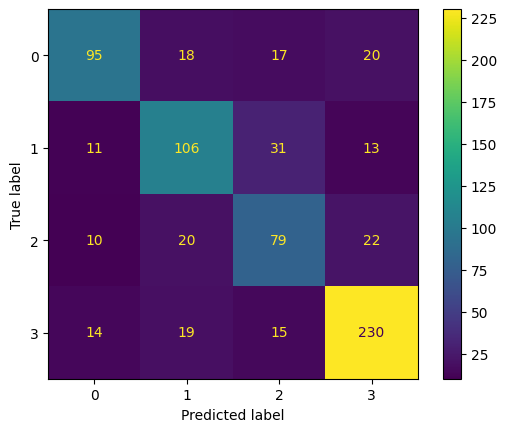

In [95]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(LR, X_test_vectorized, y_test)
plt.show()

SGDClassifier
---

In [96]:
from sklearn.linear_model import SGDClassifier 
SGD = SGDClassifier(
                    penalty="l1",
                    class_weight="balanced",
                    random_state=42 
                )
SGD.fit(X_train_vectorized, y_train)  
y_pred = SGD.predict(X_test_vectorized)  
print(SGD.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.6958333333333333
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       150
           1       0.66      0.66      0.66       161
           2       0.59      0.54      0.56       131
           3       0.78      0.80      0.79       278

    accuracy                           0.70       720
   macro avg       0.67      0.67      0.67       720
weighted avg       0.69      0.70      0.69       720



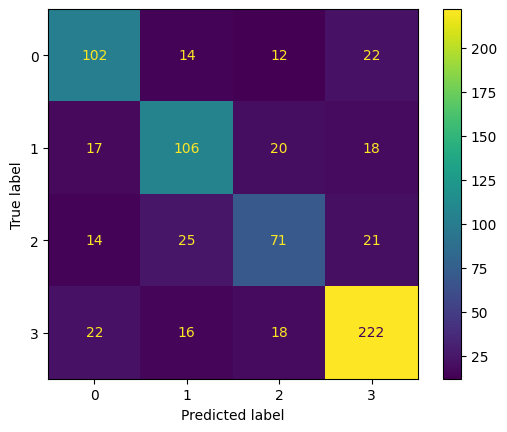

In [97]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(SGD, X_test_vectorized, y_test)
plt.show()

交叉驗證-1
---

In [98]:
from sklearn.model_selection import cross_val_score

print("LR : " , cross_val_score(LR, X_test_vectorized, y_test, cv=5).mean())
print("SVC : ",cross_val_score(SVC_model, X_test_vectorized, y_test, cv=5).mean())
print("SGD : ",cross_val_score(SGD, X_test_vectorized, y_test, cv=5).mean())
print("RF : ",cross_val_score(RF, X_test_vectorized, y_test, cv=5).mean())

LR :  0.5930555555555556
SVC :  0.6305555555555556
SGD :  0.6152777777777778
RF :  0.5888888888888889


# 超參數搜尋

linear-svc
---

In [182]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

svc_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [1e-2 , 0.1 , 1 ,2 ,3],
    'tol': [1e-5 , 1e-4 , 1e-3]
}

svc_model = LinearSVC(random_state=42 , class_weight="balanced")
grid_svc = GridSearchCV(
    svc_model, 
    svc_param_grid, 
    cv=5, 
    scoring='f1_weighted' ,
    verbose=1, 
    n_jobs=-1
)
grid_svc.fit(X_train_vectorized, y_train)

print(grid_svc.best_score_)
print(grid_svc.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0.7051798681024033
{'C': 1, 'penalty': 'l1', 'tol': 1e-05}


In [183]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, grid_svc.predict(X_test_vectorized))

0.7111111111111111

In [184]:
print(classification_report(y_test, grid_svc.predict(X_test_vectorized)))

              precision    recall  f1-score   support

           0       0.72      0.65      0.69       150
           1       0.67      0.68      0.67       161
           2       0.60      0.60      0.60       131
           3       0.77      0.82      0.80       278

    accuracy                           0.71       720
   macro avg       0.69      0.69      0.69       720
weighted avg       0.71      0.71      0.71       720



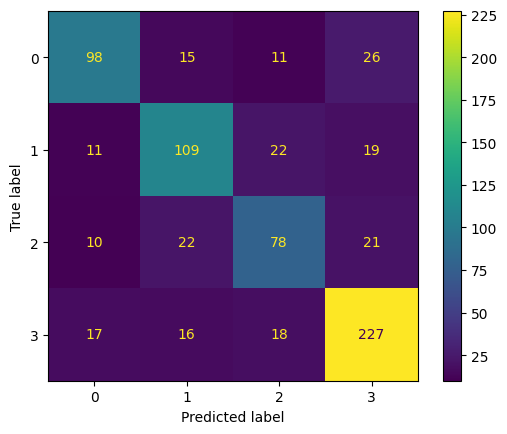

In [185]:
ConfusionMatrixDisplay.from_estimator(grid_svc.best_estimator_, X_test_vectorized, y_test)
plt.show()

logistic-regression
---

In [116]:
from sklearn.linear_model import LogisticRegression 
lr_param_grid_elasticnet = {
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.1 , 0.5 ,0.7, 0.9, 1.0],
    'C': [1e-2, 0.1, 1, 2,3],
    'tol': [1e-3, 1e-4],
}

lr_param_grid_others = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'C': [0.1, 1, 2, 3 , 4],
    'tol': [1e-3, 1e-4],
}

lr_model = LogisticRegression(
                              class_weight='balanced',
                              max_iter=1000,
                              random_state=42
                            )
grid_lr_elasticnet = GridSearchCV(
  lr_model, 
  lr_param_grid_elasticnet, 
  cv=5, 
  scoring='f1_weighted' , 
  verbose=1, 
  n_jobs=-1
)
grid_lr_elasticnet .fit(X_train_vectorized, y_train)

print(grid_lr_elasticnet .best_score_)
print(grid_lr_elasticnet .best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.71325900604697
{'C': 2, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 0.001}


In [117]:
grid_lr_others = GridSearchCV(
  lr_model, 
  lr_param_grid_others, 
  cv=5, 
  scoring='f1_weighted' , 
  verbose=1, 
  n_jobs=-1
)
grid_lr_others .fit(X_train_vectorized, y_train)

print(grid_lr_others .best_score_)
print(grid_lr_others .best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.7139708517347689
{'C': 2, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}


In [136]:
from sklearn.metrics import accuracy_score
print("elasticnet")
print(accuracy_score(y_test, grid_lr_elasticnet.predict(X_test_vectorized)))
print("L1 L2") 
print(accuracy_score(y_test, grid_lr_others.predict(X_test_vectorized)))

elasticnet
0.7291666666666666
L1 L2
0.7208333333333333


In [119]:
print(classification_report(y_test, grid_lr_elasticnet.predict(X_test_vectorized)))


              precision    recall  f1-score   support

           0       0.73      0.69      0.71       150
           1       0.67      0.70      0.69       161
           2       0.59      0.60      0.60       131
           3       0.83      0.83      0.83       278

    accuracy                           0.73       720
   macro avg       0.71      0.70      0.70       720
weighted avg       0.73      0.73      0.73       720



In [120]:
print(classification_report(y_test, grid_lr_others.predict(X_test_vectorized)))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       150
           1       0.69      0.66      0.68       161
           2       0.61      0.60      0.61       131
           3       0.80      0.83      0.81       278

    accuracy                           0.72       720
   macro avg       0.70      0.70      0.70       720
weighted avg       0.72      0.72      0.72       720



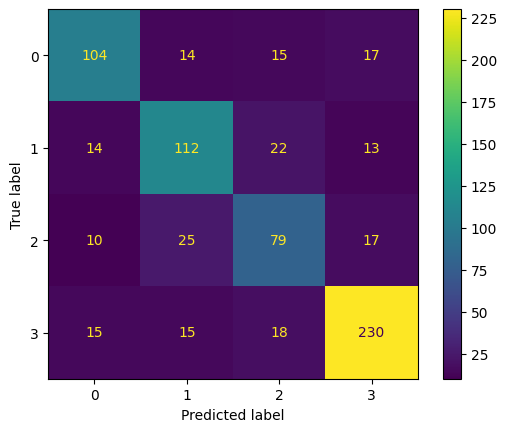

In [121]:
ConfusionMatrixDisplay.from_estimator(grid_lr_elasticnet.best_estimator_, X_test_vectorized, y_test)
plt.show()

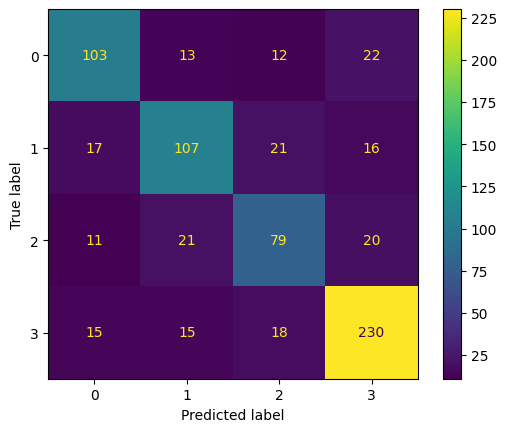

In [122]:
ConfusionMatrixDisplay.from_estimator(grid_lr_others.best_estimator_, X_test_vectorized, y_test)
plt.show()

SGDClassifier
---

In [123]:
from sklearn.linear_model import SGDClassifier
grid_elasticnet = {
    'penalty': ['elasticnet'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'l1_ratio': [0.7, 0.9, 1.0],
    'epsilon': [0.1, 0.3, 0.5],
    'tol': [1e-3, 1e-2]
}

grid_others = {
    'penalty': ['l1', 'l2'],
    'alpha': [1e-5, 1e-4, 1e-3 , 1e-2 , 0.1],
    'epsilon': [0.1, 0.3, 0.5],
    'tol': [1e-3, 1e-2]
}

# 分別跑兩次 GridSearch，再比較最佳參數


sgd_model = SGDClassifier(class_weight="balanced", max_iter=1000 , random_state=42 )
grid_sgd_elasticnet = GridSearchCV(
    sgd_model, 
    grid_elasticnet, 
    cv=5, 
    scoring='f1_weighted' ,
    verbose=1 , 
    n_jobs=-1
)
grid_sgd_elasticnet.fit(X_train_vectorized, y_train)

print(grid_sgd_elasticnet.best_score_)
print(grid_sgd_elasticnet.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
0.6913691538191858
{'alpha': 0.0001, 'epsilon': 0.1, 'l1_ratio': 1.0, 'penalty': 'elasticnet', 'tol': 0.01}


In [124]:
grid_sgd_others= GridSearchCV(
    sgd_model, 
    grid_others, 
    cv=5, 
    scoring='f1_weighted' ,
    verbose=1 , 
    n_jobs=-1
)
grid_sgd_others.fit(X_train_vectorized, y_train)

print(grid_sgd_others.best_score_)
print(grid_sgd_others.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
0.6951455871534835
{'alpha': 0.001, 'epsilon': 0.1, 'penalty': 'l2', 'tol': 0.001}


In [125]:
from sklearn.metrics import accuracy_score
print("elasticnet")
print(accuracy_score(y_test, grid_sgd_elasticnet.predict(X_test_vectorized)))
print("L1 L2")
print(accuracy_score(y_test, grid_sgd_others.predict(X_test_vectorized)))


elasticnet
0.7013888888888888
L1 L2
0.7111111111111111


In [126]:
print(classification_report(y_test, grid_sgd_elasticnet.predict(X_test_vectorized)))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       150
           1       0.68      0.61      0.65       161
           2       0.59      0.58      0.58       131
           3       0.78      0.82      0.80       278

    accuracy                           0.70       720
   macro avg       0.68      0.67      0.68       720
weighted avg       0.70      0.70      0.70       720



In [127]:
print(classification_report(y_test, grid_sgd_others.predict(X_test_vectorized)))

              precision    recall  f1-score   support

           0       0.73      0.64      0.68       150
           1       0.68      0.65      0.66       161
           2       0.61      0.55      0.58       131
           3       0.76      0.86      0.81       278

    accuracy                           0.71       720
   macro avg       0.69      0.67      0.68       720
weighted avg       0.71      0.71      0.71       720



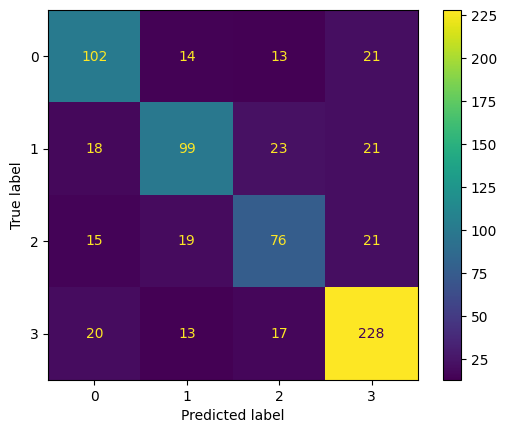

In [128]:
ConfusionMatrixDisplay.from_estimator(grid_sgd_elasticnet.best_estimator_, X_test_vectorized, y_test)
plt.show()

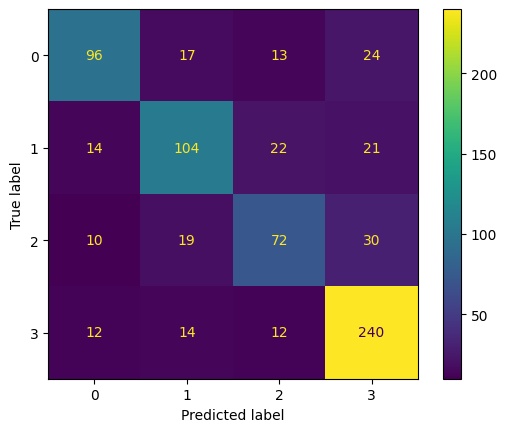

In [129]:
ConfusionMatrixDisplay.from_estimator(grid_sgd_others.best_estimator_, X_test_vectorized, y_test)
plt.show()

RandomForestClassifier
---

In [130]:
from sklearn.ensemble import RandomForestClassifier

rf_param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [150 ,200, 300 , 500],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)
grid_rf = GridSearchCV(
    rf_model, 
    rf_param_grid, 
    cv=5, 
    scoring='f1_weighted' , 
    verbose=1, 
    n_jobs=-1
)
grid_rf.fit(X_train_vectorized, y_train)

print(grid_rf.best_score_)
print(grid_rf.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.6958605524123209
{'class_weight': 'balanced', 'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


In [131]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, grid_rf.predict(X_test_vectorized))

0.7180555555555556

In [132]:
print(classification_report(y_test, grid_rf.predict(X_test_vectorized)))

              precision    recall  f1-score   support

           0       0.70      0.65      0.68       150
           1       0.64      0.65      0.64       161
           2       0.60      0.63      0.61       131
           3       0.83      0.83      0.83       278

    accuracy                           0.72       720
   macro avg       0.69      0.69      0.69       720
weighted avg       0.72      0.72      0.72       720



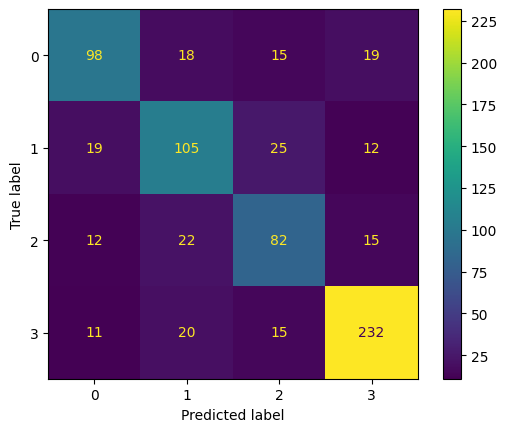

In [133]:
ConfusionMatrixDisplay.from_estimator(grid_rf.best_estimator_, X_test_vectorized, y_test)
plt.show()

交叉驗證-2
---

In [139]:
models = [
            grid_svc.best_estimator_, 
            grid_lr_elasticnet.best_estimator_,
            grid_lr_others.best_estimator_, 
            grid_sgd_elasticnet.best_estimator_,
            grid_sgd_others.best_estimator_,
            grid_rf.best_estimator_
        ]
print("每類別正確率平均	解決類別不平衡的 accuracy")
print("balanced_accuracy")
for model in models:
    print(round(cross_val_score(model, X_train_vectorized, y_train, scoring='balanced_accuracy', cv=5).mean() , 2))

每類別正確率平均	解決類別不平衡的 accuracy
balanced_accuracy
0.68
0.7
0.69
0.67
0.67
0.68


predicted_topic

In [140]:
# 使用所有模型對 X_test_vectorized 進行預測並顯示準確率
from sklearn.metrics import accuracy_score
for model in models:
    y_pred = model.predict(X_test_vectorized)
    print(f"{model.__class__.__name__} accuracy: {round(accuracy_score( y_test,y_pred ),2)}")

LinearSVC accuracy: 0.71
LogisticRegression accuracy: 0.73
LogisticRegression accuracy: 0.72
SGDClassifier accuracy: 0.7
SGDClassifier accuracy: 0.71
RandomForestClassifier accuracy: 0.72


# Ensemble Voting Soft Voting


In [228]:
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
# 經過超參數搜尋的最佳模型
# grid_svc.best_estimator_ #不支援 `predict_proba`
# grid_lr_elasticnet.best_estimator_
# grid_lr_others.best_estimator_
# grid_sgd_elasticnet.best_estimator_#不支援 `predict_proba`
# grid_sgd_others.best_estimator_#不支援 `predict_proba`
# grid_rf.best_estimator_


estimators = [
    ('lr_elasticnet', grid_lr_elasticnet.best_estimator_),
    ('lr_others', grid_lr_others.best_estimator_),
    ('rf', grid_rf.best_estimator_)
]

weights = [1,3,2]

soft_voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=weights,
    n_jobs=-1
)

# 訓練投票分類器
soft_voting_clf .fit(X_train_vectorized , y_train)
# 進行預測
y_pred_soft_voting = soft_voting_clf .predict(X_test_vectorized)



軟式投票融合模型準確率: 0.7333333333333333
軟式投票融合模型分類報告:
               precision    recall  f1-score   support

           0       0.73      0.69      0.71       150
           1       0.70      0.70      0.70       161
           2       0.61      0.60      0.60       131
           3       0.81      0.85      0.83       278

    accuracy                           0.73       720
   macro avg       0.71      0.71      0.71       720
weighted avg       0.73      0.73      0.73       720



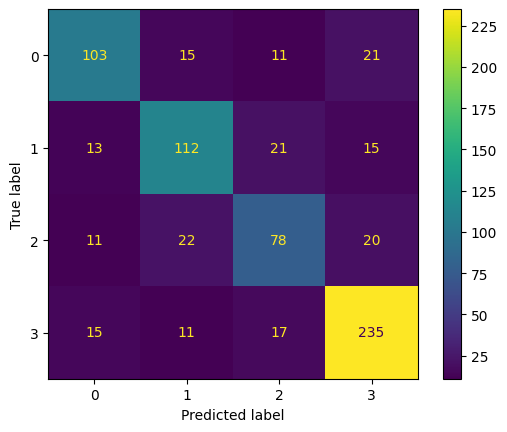

In [229]:
# 評估結果
from sklearn.metrics import classification_report, accuracy_score
print("軟式投票融合模型準確率:", accuracy_score(y_test, y_pred_soft_voting))
print("軟式投票融合模型分類報告:\n", classification_report(y_test, y_pred_soft_voting))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_soft_voting)
plt.show()

# Test  - Soft Voting - predict

In [ ]:
from gensim import matutils
import numpy as np
from sklearn.metrics import classification_report
from nlprocess import normalize_spacy
# 使用軟式投票融合模型對全部資料進行預測
# 先將所有文本轉換為向量
all_texts = [normalize_spacy(text, nlp) for text in ddf["text"]]
all_bow = [dictionary.doc2bow(text) for text in all_texts]
all_tfidf = [tfidf_model[doc] for doc in all_bow]


def bow_to_dense(corpus, dictionary):
    return np.array([
        matutils.corpus2dense([bow], num_terms=len(dictionary)).T[0]
        for bow in corpus
    ])

all_vectorized = bow_to_dense(all_tfidf, dictionary)

# 預測
all_pred = soft_voting_clf.predict(all_vectorized)

# 輸出總結報告
print(classification_report(ddf["topic"], all_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       748
           1       0.83      0.85      0.84       808
           2       0.80      0.81      0.81       654
           3       0.89      0.87      0.88      1390

    accuracy                           0.85      3600
   macro avg       0.84      0.84      0.84      3600
weighted avg       0.85      0.85      0.85      3600



# model save

In [ ]:
import joblib
import os
os.makedirs("finial_model", exist_ok=True)
# 保存軟式投票融合模型
joblib.dump(soft_voting_clf, "finial_model/soft_voting_clf.joblib")

# 保存詞典和tfidf模型
dictionary.save("finial_model/dictionary.dict")
tfidf_model.save("finial_model/tfidf_model.tfidf")

# 保存LDA主題模型
lda_model.save("finial_model/lda_model.gensim")

# # 保存最佳參數的單一模型（如有需要）
# joblib.dump(grid_lr_elasticnet.best_estimator_, "finial_model/logreg_elasticnet.joblib")
# joblib.dump(grid_lr_others.best_estimator_, "finial_model/logreg_others.joblib")
# joblib.dump(grid_rf.best_estimator_, "finial_model/random_forest.joblib")

['finial_model/random_forest.joblib']